In [1]:
%pip install jsonlines > /dev/null
%pip install matplotlib > /dev/null
%pip install numpy > /dev/null

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [26]:
from datetime import datetime
import jsonlines
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from matplotlib.ticker import PercentFormatter

In [3]:
DATA_FILE_PATH = '../data/19699af9-a096-49f4-bfed-aba837ee1995/data/2022/10/20.jsonl'

In [4]:
with jsonlines.open(DATA_FILE_PATH) as reader:
    raw_data = list(reader)

In [28]:
def createPlot(data, title):
  plt.figure(figsize=(20, 10))
  plt.title(title)

  plt.xlabel("time")
  plt.ylabel("chars per second")

  plt.yscale('symlog')

  additions = []
  deletions = []
  timestamps = []

  lastEnd = None

  for dt in data:
    start = datetime.fromisoformat(dt['start'])
    end = datetime.fromisoformat(dt['end'])
    delta = (end - start).seconds
    delta = delta if delta != 0 else 1

    if lastEnd:
      additions.extend([0, 0])
      deletions.extend([0, 0])
      timestamps.extend([lastEnd.timestamp(), start.timestamp()])
    
    if 'python' in dt['languages']:
      a = dt['languages']['python']['additions']
      d = dt['languages']['python']['deletions']
    else:
      a = 0
      d = 0
    additions.extend([a / delta, a / delta])
    deletions.extend([-d / delta, -d / delta])
    timestamps.extend([start.timestamp(), end.timestamp()])
    
    lastEnd = end

  plt.plot(timestamps, additions, label="$f_{additions}$")
  plt.plot(timestamps, deletions, label="$-f_{deletions}$")

  plt.fill_between(timestamps, additions, np.zeros(len(timestamps)))
  plt.fill_between(timestamps, deletions, np.zeros(len(timestamps)))

  plt.legend()

  locs, _ = plt.xticks()
  locs_labels = [datetime.fromtimestamp(timestamp).strftime("%H:%M") for timestamp in locs]
  plt.xticks(locs, locs_labels)

  plt.show()


In [26]:
def createPlotActions(data, title):
  plt.figure(figsize=(20, 10))
  plt.title(title)

  plt.xlabel("time")
  plt.ylabel("actions per second")

  plt.ylim(top=7)

  actions = []
  timestamps = []

  lastEnd = None

  for dt in data:
    start = datetime.fromisoformat(dt['start'])
    end = datetime.fromisoformat(dt['end'])
    delta = (end - start).seconds
    delta = delta if delta != 0 else 1

    if lastEnd:
      actions.extend([0, 0])
      timestamps.extend([lastEnd.timestamp(), start.timestamp()])
    
    if 'python' in dt['languages']:
      a = dt['languages']['python']['actions']
    else:
      a = 0
    actions.extend([a / delta, a / delta])
    timestamps.extend([start.timestamp(), end.timestamp()])
    
    lastEnd = end

  plt.plot(timestamps, actions, label="$f_{actions}$")

  plt.fill_between(timestamps, actions, np.zeros(len(timestamps)))

  plt.legend()

  locs, _ = plt.xticks()
  locs_labels = [datetime.fromtimestamp(timestamp).strftime("%H:%M") for timestamp in locs]
  plt.xticks(locs, locs_labels)

  plt.show()


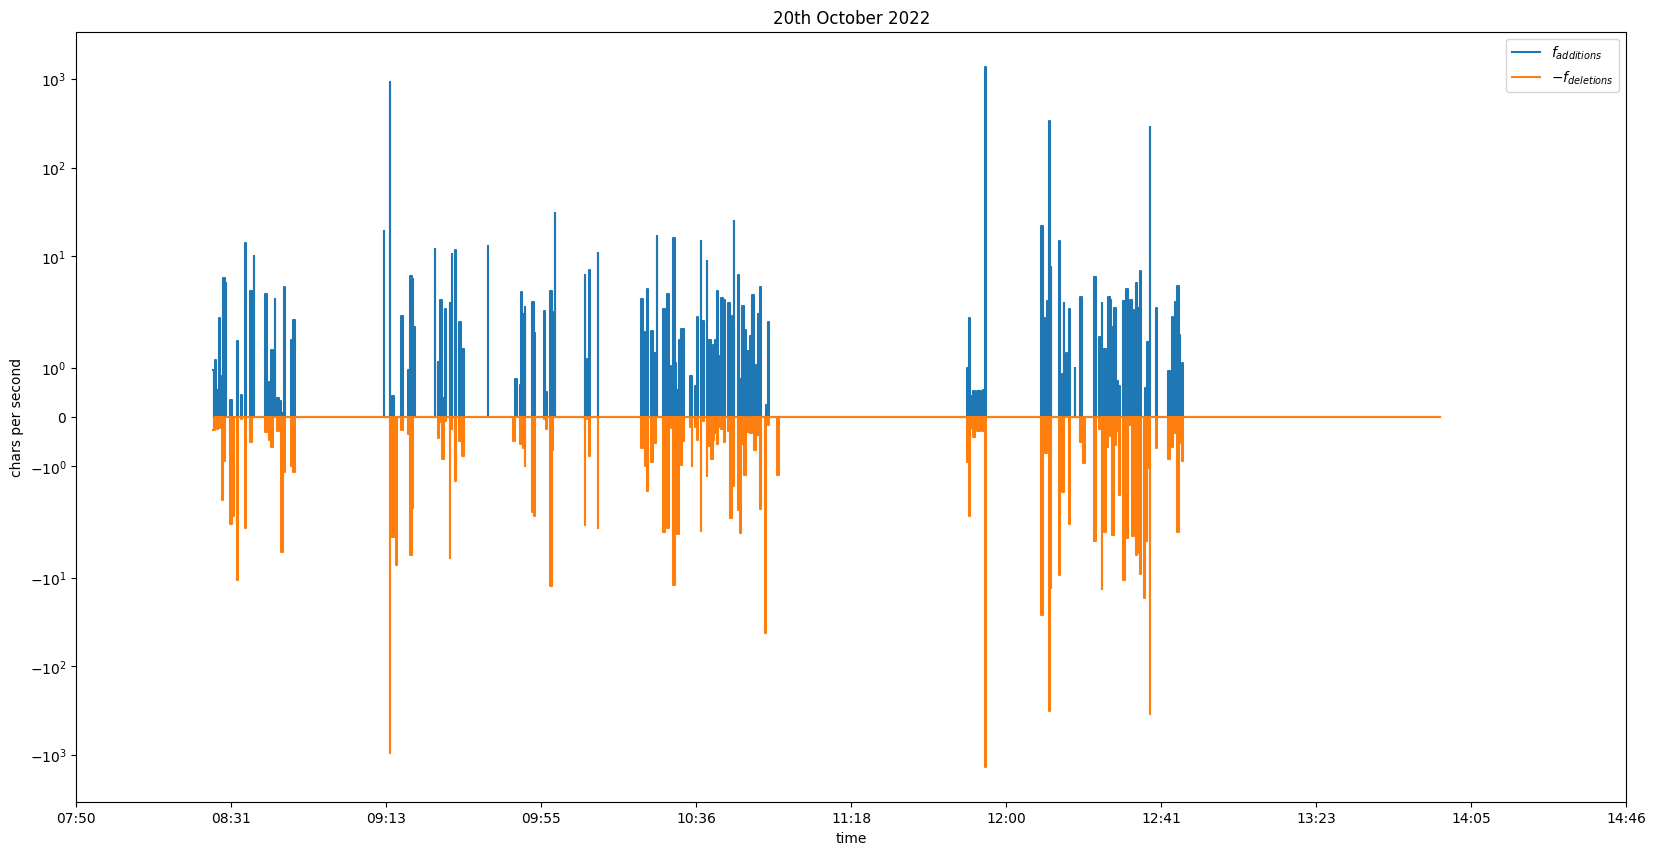

In [29]:
createPlot(raw_data, "20th October 2022")

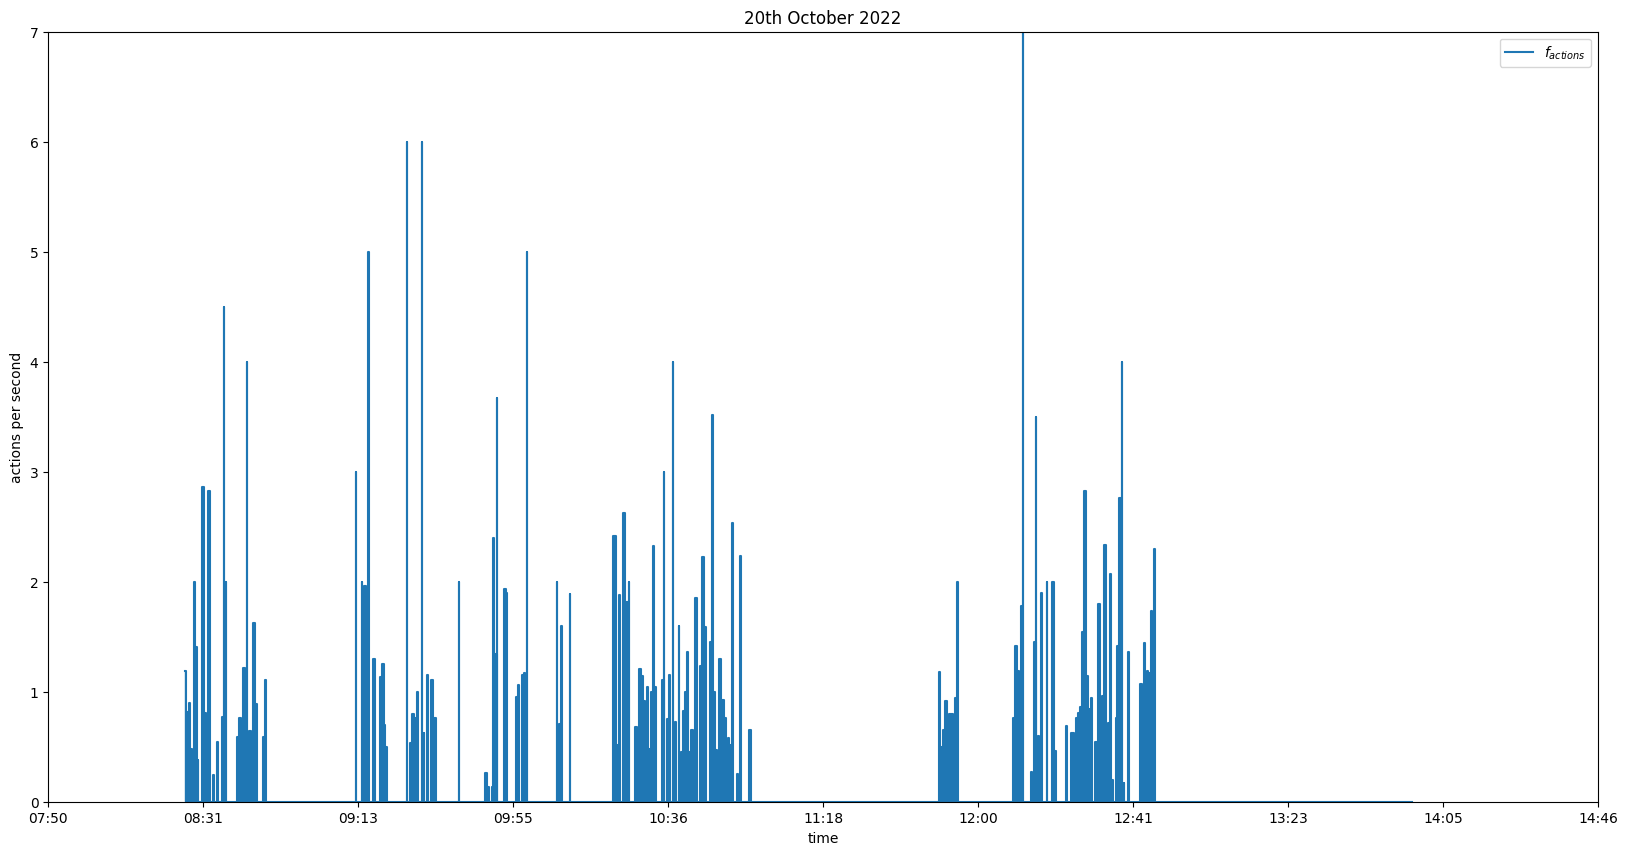

In [27]:
createPlotActions(raw_data, "20th October 2022")

In [28]:
def hours_to_arr(hours):
  hours_arr = []
  for i in range(0, 10):
    hours_arr.append(hours[f'0{i}'])
  for i in range(10, 24):
    hours_arr.append(hours[f'{i}'])
  return np.asarray(hours_arr)

In [48]:
from importlib import reload
import BasicStats

reload(BasicStats)

bs = BasicStats.BasicStats()

In [29]:
python_hours_arr = hours_to_arr(bs.time['python'])
python_hours_hist = python_hours_arr / python_hours_arr.sum() * 100

In [30]:
js_hours_arr = hours_to_arr(bs.time['javascript'])
js_hours_hist = js_hours_arr / js_hours_arr.sum() * 100

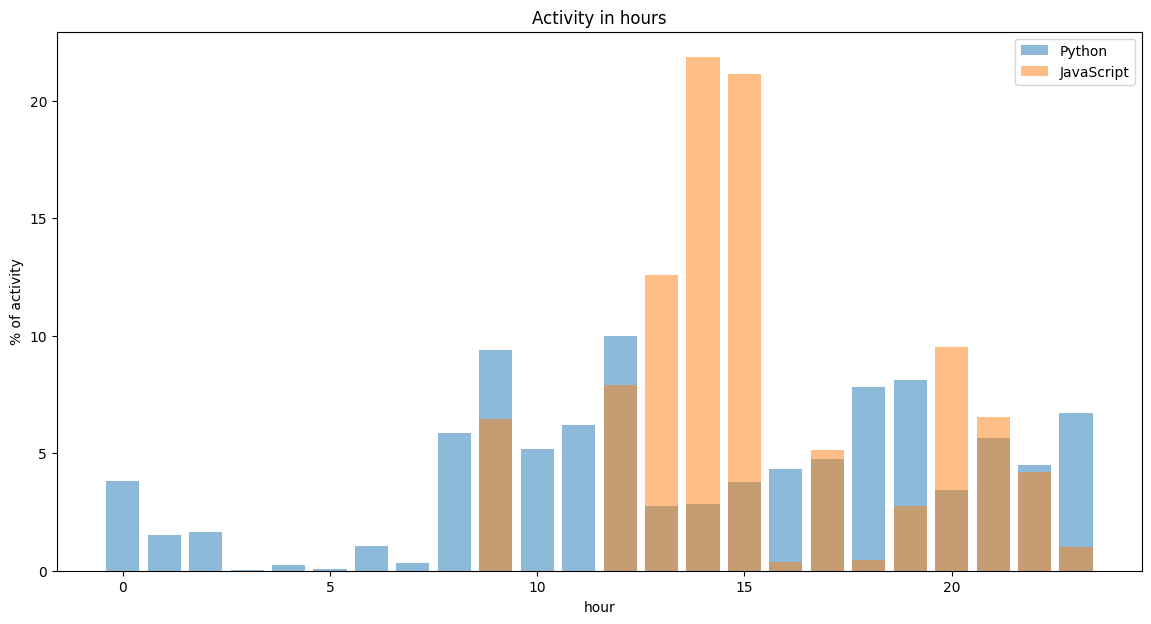

In [31]:
plt.figure(figsize=(14, 7))

plt.title("Activity in hours")

plt.xlabel("hour")
plt.ylabel("% of activity")

plt.bar(list(range(0, 24)), python_hours_hist, label="Python", alpha=0.5)
plt.bar(list(range(0, 24)), js_hours_hist, label="JavaScript", alpha=0.5)

plt.legend()
plt.show()

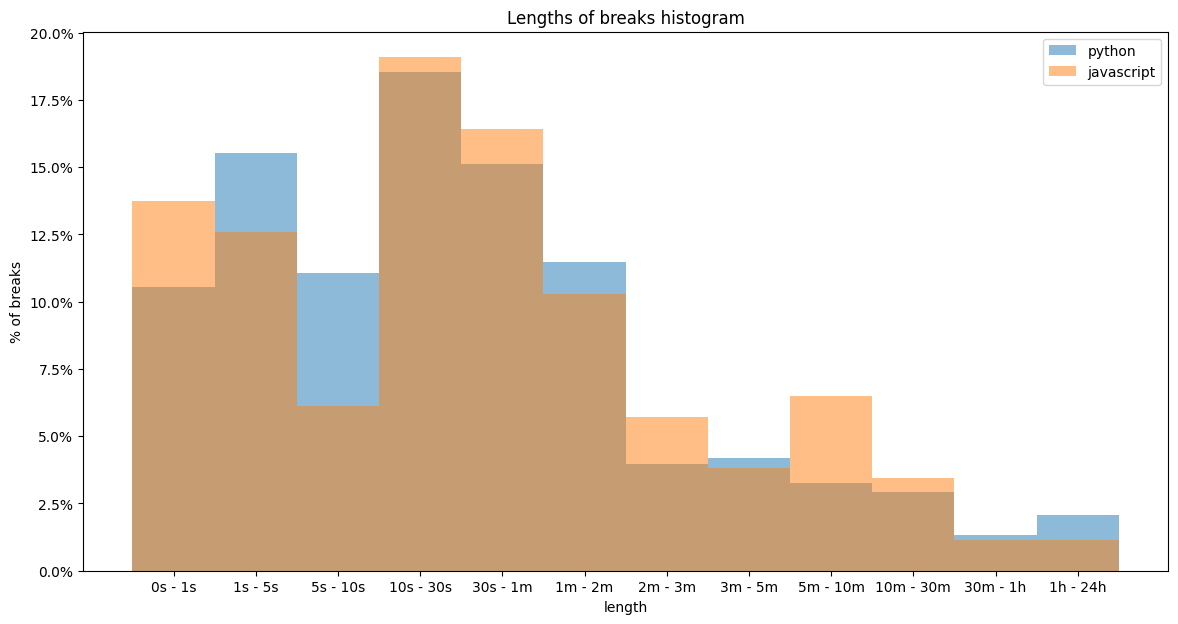

In [32]:
plt.figure(figsize=(14, 7))

plt.title("Lengths of breaks histogram")

plt.xlabel("length")
plt.ylabel("% of breaks")

python_breaks = np.asarray(bs.breaks['python'])
javascript_breaks = np.asarray(bs.breaks['javascript'])

bins = [0, 1, 5, 10, 30, 60, 120, 180, 300, 600, 1800, 3600, 86400]
bin_labels = ['0s', '1s', '5s', '10s', '30s', '1m', '2m', '3m', '5m', '10m', '30m', '1h', '24h']
python_hist, _ = np.histogram(python_breaks, bins, weights=np.ones_like(python_breaks)/python_breaks.shape[0])
js_hist, _ = np.histogram(javascript_breaks, bins, weights=np.ones_like(javascript_breaks)/javascript_breaks.shape[0])

plt.xticks(range(len(python_hist)), [f'{a} - {b}' for a, b in zip(bin_labels[:-1], bin_labels[1:])])
plt.axis()
plt.bar(range(len(python_hist)), python_hist, width=1, align='center', alpha=0.5, label="python")
plt.bar(range(len(js_hist)), js_hist, width=1, align='center', alpha=0.5, label="javascript")

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.legend()
plt.show()

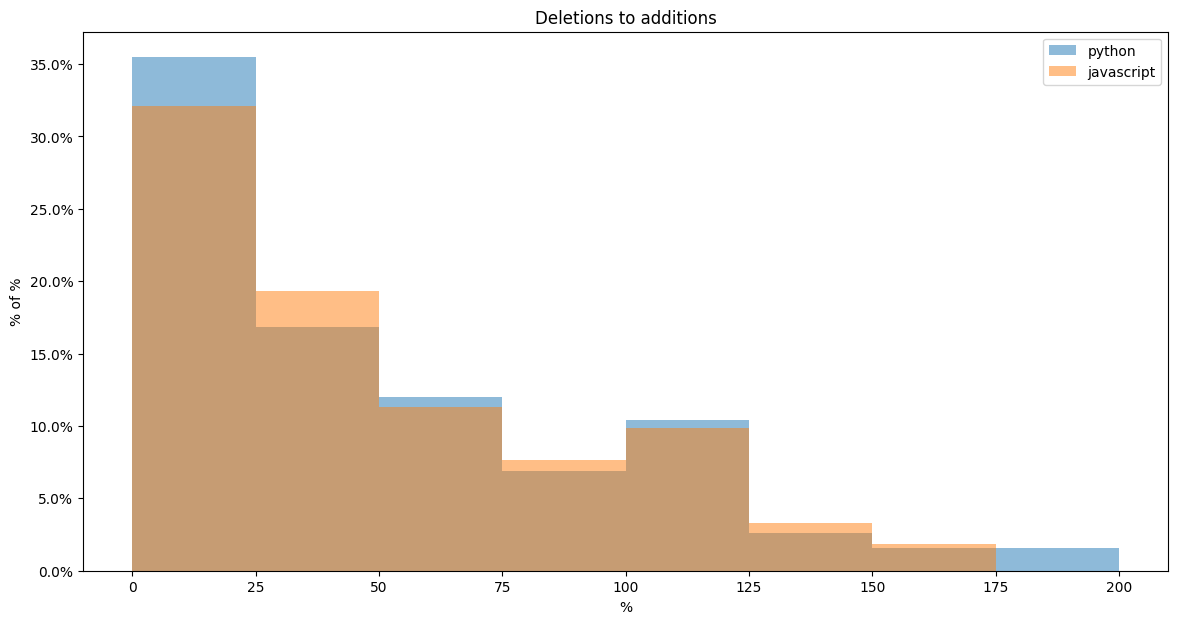

In [33]:
plt.figure(figsize=(14, 7))

plt.title("Deletions to additions")

plt.xlabel("%")
plt.ylabel("% of %")

python_rel = np.asarray(bs.del_to_add['python'])
javascript_rel = np.asarray(bs.del_to_add['javascript'])

plt.hist(python_rel, [0, 25, 50, 75, 100, 125, 150, 175, 200], weights=np.ones_like(python_rel)/python_rel.shape[0], alpha=0.5, label="python")
plt.hist(javascript_rel, [0, 25, 50, 75, 100, 125, 150, 175, 200], weights=np.ones_like(javascript_rel)/javascript_rel.shape[0], alpha=0.5, label="javascript")

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.legend()
plt.show()

In [34]:
projects_num_in_days = np.zeros(6)
for stats in bs.participants_stats.values():
    for projects_in_day in stats['projects_in_days']:
        if projects_in_day < 6:
            projects_num_in_days[projects_in_day] += 1
        else:
            projects_num_in_days[5] += 1
projects_num_in_days

array([ 2., 54., 17.,  3.,  1.,  0.])

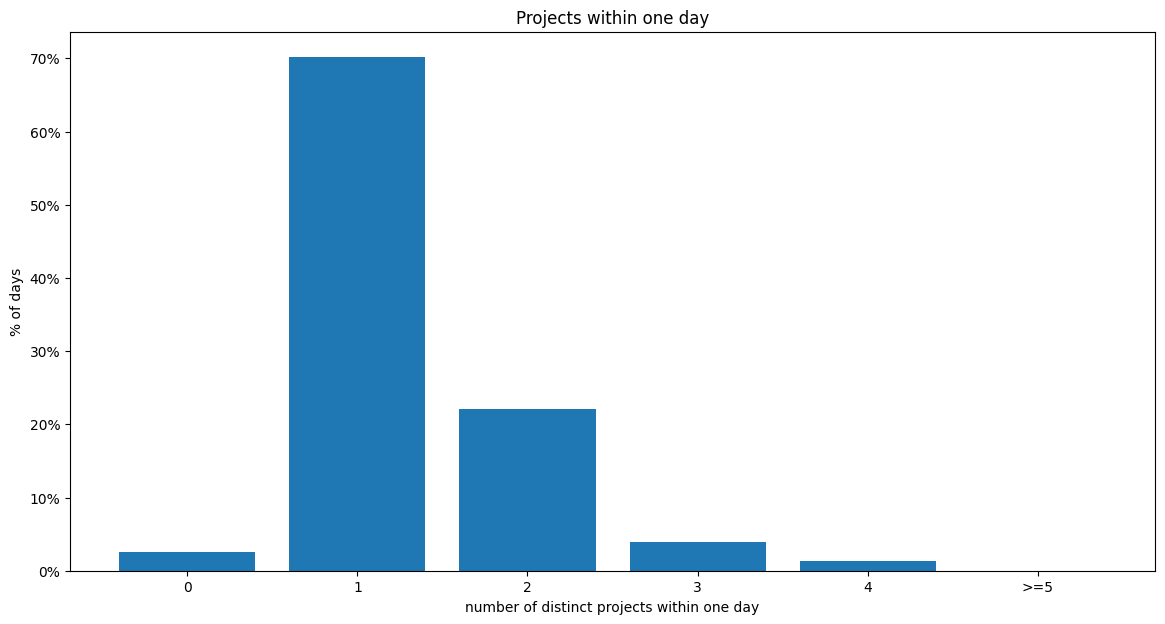

In [39]:
plt.figure(figsize=(14, 7))

plt.title("Projects within one day")

plt.xlabel("number of distinct projects within one day")
plt.ylabel("% of days")

plt.bar(list(range(6)), projects_num_in_days / projects_num_in_days.sum())
# TODO hist
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().set_xticks(list(range(6)), ['0', '1', '2', '3', '4', '>=5'])

plt.show()

In [40]:
projects_sw_in_days = np.zeros(6)
for stats in bs.participants_stats.values():
    for projects_sw_in_day in stats['switching_projects_in_days']:
        if projects_sw_in_day < 6:
            projects_sw_in_days[projects_sw_in_day] += 1
        else:
            projects_sw_in_days[5] += 1
projects_sw_in_days

array([56., 10.,  8.,  1.,  2.,  0.])

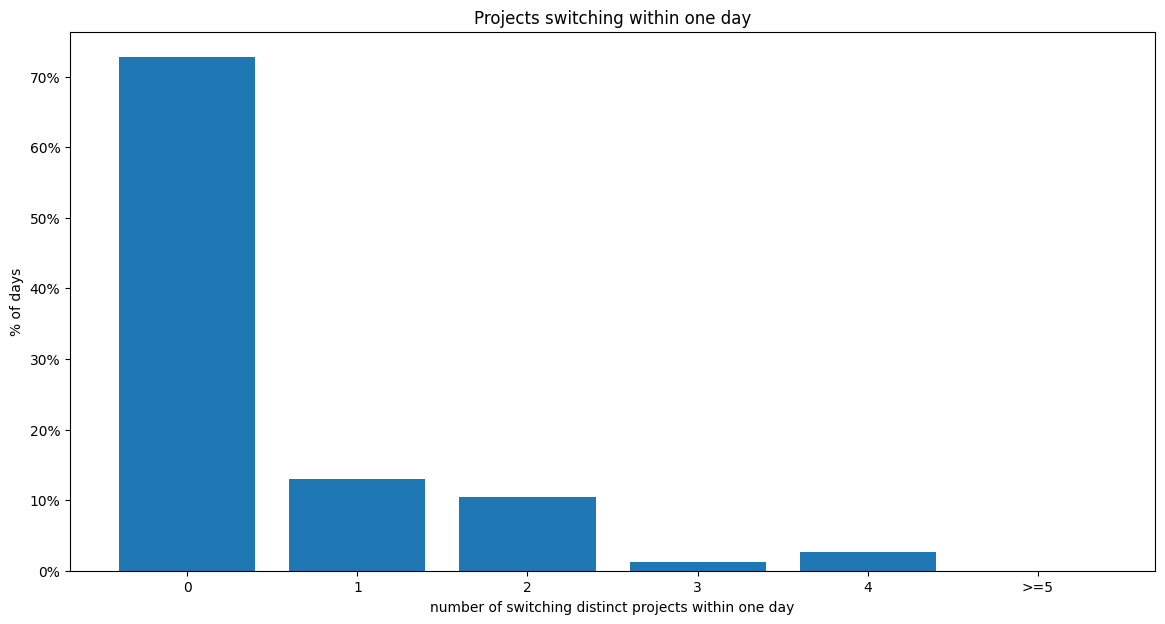

In [44]:
plt.figure(figsize=(14, 7))

plt.title("Projects switching within one day")

plt.xlabel("number of switching distinct projects within one day")
plt.ylabel("% of days")

plt.bar(list(range(6)), projects_sw_in_days / projects_sw_in_days.sum())

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().set_xticks(list(range(6)), ['0', '1', '2', '3', '4', '>=5'])

plt.show()

In [54]:
weekdays_activity = np.zeros(7)
for stats in bs.participants_stats.values():
    weekdays_activity += np.asarray(stats['weekdays'])
weekdays_activity /= weekdays_activity.sum()

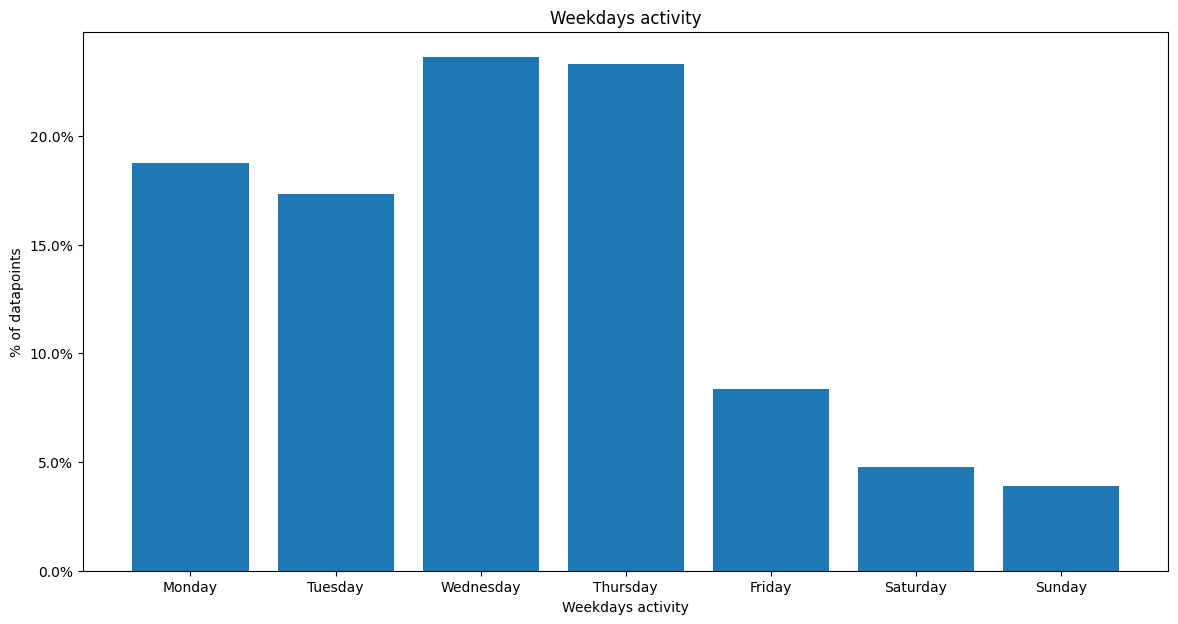

In [55]:
plt.figure(figsize=(14, 7))

plt.title("Weekdays activity")

plt.xlabel("Weekdays activity")
plt.ylabel("% of datapoints")

plt.bar(list(range(7)), weekdays_activity)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().set_xticks(list(range(7)), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()